In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import copy

from uncertainty_forest.uncertainty_forest import UncertaintyForest

from tqdm import tqdm_notebook
from joblib import Parallel, delayed
from scipy.stats import entropy, multivariate_normal
from scipy.integrate import nquad

In [2]:
def split_train_eval(X, y, frac_eval):
    
    if frac_eval == 0:
        return X, y, [], []
    
    n = len(y)
    n_eval = int(np.floor(frac_eval*n))
    eval_indices = np.random.choice(np.arange(n), size = n_eval, replace = False)
    X_eval = X[eval_indices, :]
    y_eval = y[eval_indices]
    X = np.delete(X, eval_indices, axis = 0)
    y = np.delete(y, eval_indices, axis = 0)
    
    return X, y, X_eval, y_eval

def generate_data(n, d, mu = 1, var1 = 1, pi = 0.5, truncate = False, three_class = False):
    
    means, Sigma, probs = _make_params(d, mu = mu, var1 = var1, pi = pi, three_class = three_class)
    counts = np.random.multinomial(n, probs, size = 1)[0]
    
    X_data = []
    y_data = []
    for k in range(len(probs)):
        X_data.append(np.random.multivariate_normal(means[k], Sigma, counts[k]))
        y_data.append(np.repeat(2*k - 1, counts[k]))
    X = np.concatenate(tuple(X_data))
    y = np.concatenate(tuple(y_data))
    
    if truncate:
        for i in range(n):
            if X[i, 0] > 0:
                y[i] = -1
            elif X[i, 0] < 0:
                y[i] = 1
    
    return X, y

def _make_params(d, mu = 1, var1 = 1, pi = 0.5, three_class = False):
    
    if three_class:
        return _make_three_class_params(d, mu)
    
    mean = np.zeros(d)
    mean[0] = mu
    means = [mean, -mean]
    Sigma = np.eye(d)
    Sigma[0, 0] = var1
    probs = [pi, 1 - pi]
    
    return means, Sigma, probs

def _make_three_class_params(d, mu):
    
    means = []
    mean = np.zeros(d)
    mean[d-1] = mu
    means.append(copy.deepcopy(mean))
    
    mean[d-1] = 0
    mean[0] = mu
    means.append(copy.deepcopy(mean))
    
    mean[0] = -mu
    means.append(copy.deepcopy(mean))
                      
    Sigma = np.eye(d)
    probs = [1/3.]*3
    
    return means, Sigma, probs

def split_by_class(X, y):
    
    classes, class_indices = np.unique(y, return_inverse = True)
    K = len(classes)
    X_by_class = []
    y_by_class = []
    
    for k in range(K):
        class_ = classes[k]
        X_k = X[y == class_,:]
        y_k = np.repeat(class_, X_k.shape[0])
        X_by_class.append(X_k)
        y_by_class.append(y_k)
        
    return X_by_class, y_by_class

In [ ]:
def plot_setting(n, setting, ax):
    
    X, y = generate_data(n, 2, **setting['kwargs'])
        
    X_by_class, y_by_class = split_by_class(X, y)
    for k in range(len(y_by_class)):
        ax.scatter(X_by_class[k][:, 0], X_by_class[k][:, 1], color = setting['colors'][k], marker = ".")
    
    ax.set_ylim(bottom = -5.05)
    ax.set_ylim(top = 5.05)
    ax.set_xlim(left = -5.05)
    ax.set_xlim(right = 5.05)
    
    ax.set_ylabel(setting['name'])

In [3]:
def compute_norm_mutual_info(d, base = 2, mu = 1, var1 = 1, pi = 0.5, three_class = False, truncate = False):
    
    if truncate:
        return 1.0, 1.0, 1.0 # TO DO: Compute entropy of X.
    
    # For the settings of interest, adding noise dimensions does not change the resulting mutual information.
    if d > 1:
        d = 2
    
    means, Sigma, probs = _make_params(d, mu = mu, var1 = var1, pi = pi, three_class = three_class)
    
    # Compute entropy and X and Y.
    def func(*args):
        x = np.array(args)
        p = 0
        for k in range(len(means)):
            p += probs[k] * multivariate_normal.pdf(x, means[k], Sigma)
        return -p * np.log(p) / np.log(base)

    scale = 10
    lims = [[-scale, scale]]*d
    H_X, int_err = nquad(func, lims)
    H_Y = entropy(probs, base = base)
    
    # Compute MI.
    H_XY = (d * np.log(2*np.pi) + np.log(np.linalg.det(Sigma)) + d) / (2 * np.log(base))
    I_XY = H_X - H_XY
    
    return I_XY, H_X, H_Y

In [4]:
def mutual_info_distribution(n, d, frac_eval, algo, num_trials, setting, base = 2, parallel = False):
    # For each trial, generate data and compute conditional entropy for each algorithm.
    def worker(t):
        X, y = generate_data(n, d, **setting['kwargs'])
        X, y, X_eval, _ = split_train_eval(X, y, frac_eval)

        # Estimate conditional probability of Y | X.
        obj = algo['instance']
        obj.fit(X, y)
        return obj.estimate_mutual_info(X_eval)
    
    if parallel:
        predicted_mutual_info = np.array(Parallel(n_jobs=-2)(delayed(worker)(t) for t in range(num_trials)))
    else:
        predicted_mutual_info = np.zeros(num_trials)
        for t in tqdm_notebook(range(num_trials)):
            predicted_mutual_info[t] = worker(t)
            
    return predicted_mutual_info

In [23]:
def MI_by_algo_d(alpha, d, n, scale, frac_eval, algo, num_trials, setting, parallel, I_XY):
    mi_est = np.mean(mutual_info_distribution(n, d, frac_eval, algo, num_trials, setting, parallel = parallel), axis = 0)
    rel_err = np.abs(mi_est - I_XY) / I_XY
    while rel_err > alpha:
        print("Checking if %s converges in %d samples for %s." % (algo['title'], scale*n, setting['name']))
        return MI_by_algo_d(alpha, d, n*scale, scale, frac_eval, algo, num_trials, setting, parallel, I_XY)
    print("Running binary search.")
    return binary_search(alpha, d, n, scale, frac_eval, algo, num_trials, setting, parallel, I_XY)

def binary_search(alpha, d, n, scale, frac_eval, algo, num_trials, setting, parallel, I_XY):
    start = n // 2
    end = n
    mid = (start + end) // 2
    prev_mid = 0
    
    mi_est = np.mean(mutual_info_distribution(mid, d, frac_eval, algo, num_trials, setting, parallel = parallel), axis = 0)
    rel_err = np.abs(mi_est - I_XY) / I_XY
    while np.abs(prev_mid - mid) > 5:
        prev_mid = mid
        if rel_err > alpha:
            start = mid
        else:
            end = mid
        mid = (start + end) // 2
        mi_est = np.mean(mutual_info_distribution(mid, d, frac_eval, algo, num_trials, setting, parallel = parallel), axis = 0)
        rel_err = np.abs(mi_est - I_XY) / I_XY
    return mid

In [24]:
# Compute the number of trials until with 5% of the true MI.
def mutual_info_by_d(alpha, scale, ds, frac_eval, algos, num_trials, setting, base = 2, parallel = False):
    
    
    # Repeat for all 'd', and save output in the 'algos' array.
    num_sample_range = np.zeros((len(ds), len(algos)))
    starting_n = 20
    MI_by_algo = np.repeat(1000, len(algos))
    
    # Increase n until estimate is within 5% of the true I_XY.
    for i in range(len(ds)):
        I_XY = compute_norm_mutual_info(ds[i], **setting['kwargs'])[0]
        for j in range(len(algos)):
            num_sample_range[i, j] = MI_by_algo_d(alpha, 
                                                  ds[i], 
                                                  starting_n, 
                                                  scale, 
                                                  frac_eval, 
                                                  algos[j], 
                                                  num_trials, 
                                                  setting,
                                                  parallel, 
                                                  I_XY)
                             
    for j in range(len(algos)):
        algos[j]['mi_by_d_%s' % setting['filename']] = num_sample_range[:, j]
        
    with open('algos_fig4.pkl', 'wb') as f:
        pickle.dump(algos, f)
    with open('ds_fig4.pkl', 'wb') as f:
        pickle.dump(ds, f)
        
    return algos

In [25]:
# Setting figures.
colors = ["#d95f02", "#2166ac", "#c51b7d"]
settings = [
    {
        'name' : 'Sphereical Gaussians',
        'kwargs': {},
        'colors' : colors[1:3],
        'filename' : 'spherical'
    },
    {
        'name' : 'Elliptical Gaussians',
        'kwargs': {'var1' : 3},
        'colors' : colors[1:3],
        'filename' : 'ellyptical'
    },
#     {
#         'name' : 'Imbalanced Classes',
#         'kwargs': {'pi' : 0.8},
#         'colors' : colors[1:3],
#         'filename' : 'imbalanced'
#     },
#     {
#         'name' : 'Truncated Gaussians',
#         'kwargs': {'truncate' : True},
#         'colors' : colors[1:3],
#         'filename' : 'truncated'
#     },
#     {
#         'name' : 'Three Class Gaussians',
#         'kwargs': {'mu' : 3, 'three_class' : True},
#         'colors' : colors,
#         'filename' : 'three_class'
#     },
]

In [26]:
# Data.
num_trials = 3
frac_eval = 0.3
scale = 2
alpha = 0.30
ds = range(1, 3, 1)

# Algorithms.
algos = [
#     {
#         'instance': RandomForestClassifier(min_samples_leaf = 6, n_estimators = 30),
#         'label': 'KSG',
#         'title': 'KSG',
#         'color': "#1b9e77",
#     },
    {
        'instance': UncertaintyForest(finite_correction = False, min_samples_leaf = 6, n_estimators = 30),
        'label': 'Mixed KSG',
        'title': 'Mixed KSG',
        'color': "#fdae61",
    },
    {
        'instance': UncertaintyForest(min_samples_leaf = 6, n_estimators = 30),
        'label': 'UF',
        'title': 'Uncertainty Forest',
        'color': "#F41711",
    },
]

# Other.
num_plotted_trials = 3
parallel = False

In [27]:
for setting in settings:
    algos = mutual_info_by_d(alpha, scale, ds, frac_eval, algos, num_trials, setting, parallel = parallel)


Checking if Mixed KSG converges in 40 samples for Sphereical Gaussians.



Running binary search.



Checking if Uncertainty Forest converges in 40 samples for Sphereical Gaussians.



Checking if Uncertainty Forest converges in 80 samples for Sphereical Gaussians.



Running binary search.



Checking if Mixed KSG converges in 40 samples for Sphereical Gaussians.



Running binary search.



Checking if Uncertainty Forest converges in 40 samples for Sphereical Gaussians.



Checking if Uncertainty Forest converges in 80 samples for Sphereical Gaussians.



Running binary search.



Checking if Mixed KSG converges in 40 samples for Elliptical Gaussians.



Checking if Mixed KSG converges in 80 samples for Elliptical Gaussians.



Running binary search.



Checking if Uncertainty Forest converges in 40 samples for Elliptical Gaussians.



Checking if Uncertainty Forest converges in 80 samples for Elliptical Gaussians.



Checking if Uncertainty Forest converges in 160 samples for Elliptical Gaussians.



Running binary search.



Checking if Mixed KSG converges in 40 samples for Elliptical Gaussians.



Checking if Mixed KSG converges in 80 samples for Elliptical Gaussians.



Checking if Mixed KSG converges in 160 samples for Elliptical Gaussians.



Running binary search.



Checking if Uncertainty Forest converges in 40 samples for Elliptical Gaussians.



Checking if Uncertainty Forest converges in 80 samples for Elliptical Gaussians.



Running binary search.


In [28]:
def plot_mutual_info_by_d(ds, setting, algos, ax, alpha):
    for algo in algos:
        # Plot the mean over trials as a solid line.
        ax.plot(ds, 
                algo['mi_by_d_%s' % setting['filename']], 
                label = algo['label'], 
                linewidth = 2, 
                color = algo['color'])

    ax.set_xlabel("Number of Dimensions")
    ax.set_ylabel("Sample Size")
    
#     ax.set_ylim(bottom = -0.05)
#     ax.set_ylim(top = 1.05)
    ax.set_xlim(left = .95)
    ax.set_xlim(right = np.max(ds) + 0.05)

In [29]:
def plot_fig4(ds, algos, settings, alpha):
    sns.set(font_scale = 1.4)
    sns.set_style("ticks")
    plt.figure()
    plt.rcParams["font.family"] = "sans-serif"
    fig, axes = plt.subplots(len(settings), 1, figsize = (5,20))

    for s in range(len(settings)):
        plot_mutual_info_by_d(ds, settings[s], algos, axes[s], alpha)

    plt.yticks(fontsize = 20)
    plt.xticks(fontsize = 20)
    plt.tight_layout()
    plt.savefig("fig4_d.pdf")
    plt.show()

<Figure size 432x288 with 0 Axes>

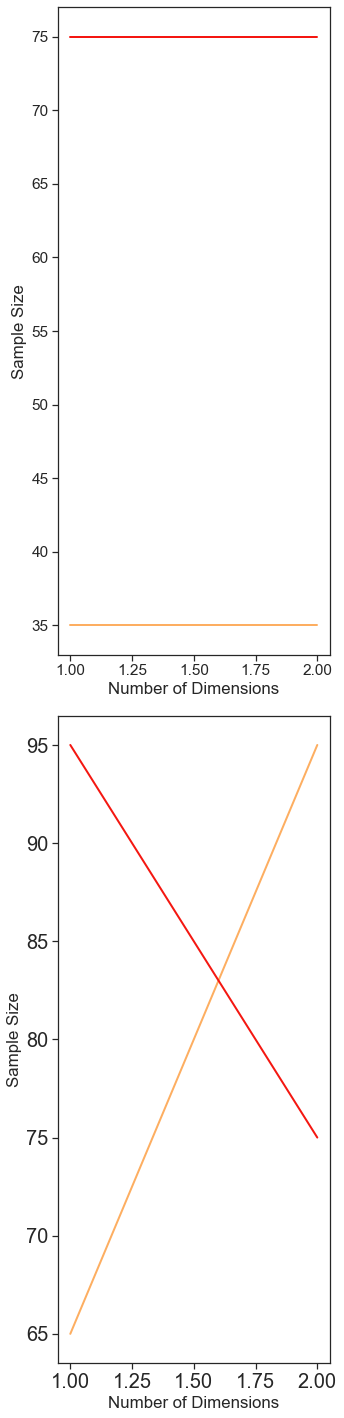

In [30]:
plot_fig4(ds, algos, settings, alpha)

In [ ]:
print(algos[0])